In [1]:
!pip install -q openai stable_baselines3 huggingface_hub bitsandbytes datasets peft accelerate safetensors sentencepiece gymnasium shimmy wandb
!pip install -q git+https://github.com/huggingface/diffusers
!pip install -q git+https://github.com/huggingface/transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.14.1 requires huggingface_hub<0.18,>=0.16.4, but you have huggingface-hub 0.19.4 which is incompatible.


Prompt generation using LLM

In [2]:
import json
import os
from pprint import pprint
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
#from datasets import load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#notebook_login()

import gymnasium
import numpy as np
import pandas as pd
import torch
from gymnasium import spaces
import time
from PIL import Image
import os
import stable_baselines3
import pandas as pd

import wandb
wandb.login()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
MODEL_NAME = "jeong-jasonji/CSE574_prompter"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_gen = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

generation_config = model_gen.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.1
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

device = "cuda:0"

config.json:   0%|          | 0.00/912 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import huggingface_hub


def generate_prompt_transformer(company, strategy):

    action = "make a convincing ad for "+ company + " with themes of " + strategy
    encoding = tokenizer(action, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model_gen.generate(
          input_ids = encoding.input_ids,
          attention_mask = encoding.attention_mask,
          generation_config = generation_config,
          max_new_tokens = 77
      )
      prompt = tokenizer.decode(outputs[0], skip_special_tokens=True)
      return prompt


prompt = generate_prompt_transformer("h&m","elegance")
prompt

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


'make a convincing ad for h&m with themes of elegance, elegance, and choice, by John William Godward and Arthur Rackham and Robert Hubert and Zdzisław Beksiński and Francisco de Goya, open ceiling, highly detailed, painted by Francis Bacon, painted by James Gilleard, surrealism, airbrush, Ilya Kuvshinov, WLOP, Stanley Artger'

In [5]:
df=pd.read_csv("/kaggle/input/cse574/ratings_images_1.csv")
df

,names,Average
0,cocacola_authority_image_1.jpg,2
1,cocacola_authority_image_2.jpg,0
2,cocacola_authority_image_3.jpg,3
3,cocacola_authority_image_4.jpg,0
4,cocacola_authority_image_5.jpg,2
...,...,...
370,kfc_trustworthiness_image_21.jpg,1
371,kfc_trustworthiness_image_22.jpg,3
372,kfc_trustworthiness_image_23.jpg,3
373,kfc_trustworthiness_image_24.jpg,5


In [6]:
import torch.nn as nn
from transformers import BertModel, BertConfig, BertTokenizer,DistilBertConfig
from transformers import DistilBertTokenizer, DistilBertModel

from transformers import AutoTokenizer
import torch
from transformers import BertModel, BertConfig, AutoTokenizer

class TextEncoder(torch.nn.Module):
    def __init__(self, tokenizer, bert_model):
        super(TextEncoder, self).__init__()
        self.tokenizer = tokenizer
        config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        config.num_hidden_layers = 3
        self.bert = bert_model.from_pretrained("bert-base-uncased", config=config).to("cuda")

    def forward(self, inputs):
        inputs = [inputs] if isinstance(inputs, str) else inputs

        max_length_batch = 10

        encoding = self.tokenizer.batch_encode_plus(
            inputs,
            truncation=True,
            return_tensors='pt',
            padding='longest',
            max_length=max_length_batch,
            return_attention_mask=True
        )

        input_ids = encoding["input_ids"].to("cuda")
        attention_mask = encoding["attention_mask"].to("cuda")

        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_mask)
            last_hidden_states = outputs.last_hidden_state

        cls_representation = last_hidden_states[:, 0, :]

        reduced_representation = cls_representation[:, :64]

        return reduced_representation

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel

model = TextEncoder(tokenizer, bert_model)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./tensorboard_logs')
wandb.tensorboard.patch(root_logdir="./tensorboard_logs")

In [8]:
wandb.init(project="cse474")

wandb: Currently logged in as: subbu24. Use `wandb login --relogin` to force relogin


In [9]:
%tensorboard --logdir /content/tensorboard_logs


In [10]:
import gym
from gym import spaces
import numpy as np
import torch
import pandas as pd

class AdsEnv(gym.Env):
    def __init__(self, persuasion_strategies, model, products, df):
        super().__init__()
        self.persuasion_strategies = persuasion_strategies
        self.action_space = spaces.Discrete(len(self.persuasion_strategies))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(64,), dtype=np.float32)
        self.model = model
        self.products = products
        self.df = df
        self.current_product_index = 0
        self.current_strategy_index=0
        self.current_strategy = None
        self.current_product = None
        self.reset()

    def encode_observation(self, text):
        with torch.no_grad():
            encoded_text = self.model(text).cpu().numpy()
        return encoded_text

    def get_reward(self, product_name, strategy):
        product_name = product_name.lower()
        strategy = strategy.lower()
        mask = self.df['names'].str.contains(product_name) & self.df['names'].str.contains(strategy)
        filtered_df = self.df[mask]

        if not filtered_df.empty:
            average_score = filtered_df['Average'].mean()
            return average_score
        else:
            return 0

    def reset(self):
       
        self.current_product_index = np.random.choice(len(self.products))
        self.current_product = self.products[self.current_product_index]

        
        self.current_strategy_index = np.random.choice(len(self.persuasion_strategies))
        observation = self.encode_observation(self.current_product)
        return observation

      
    def step(self, action):
        action = action % len(self.persuasion_strategies)
        self.current_strategy = self.persuasion_strategies[action]
        reward = self.get_reward(self.current_product, self.current_strategy)
        done = True
        observation = self.encode_observation(self.current_product)
        info = {'product': self.current_product, 'strategy': self.current_strategy}
        return observation, reward, done, info

    def render(self, mode="human"):
        pass


In [11]:
df['names'].apply(lambda x: x.split('_')[1]).unique()

array(['authority', 'emotion(eager)', 'guarantees', 'socialproof',
       'trustworthiness', 'anchoring&comparison', 'concreteness',
       'fashionable', 'reciprocity', 'socialidentity', 'scarcity'],
      dtype=object)

In [12]:
# persuasion_strategies = ["Liking", "SocialProof", "Scarcity", "Authority", "Consistency", "Reciprocity", "Contrast", "Unity", "Consensus", "Emotion", "Scarcity", "Urgency", "Exclusivity", "Curiosity", "Anticipation", "Mystery", "Surprise", "Humor"]
persuasion_strategies=['authority', 'emotion(eager)', 'guarantees', 'socialproof','trustworthiness', 'anchoring&comparison', 'concreteness','fashionable', 'reciprocity', 'socialidentity', 'scarcity']
products=["kfc","h&m","cocacola"]
env = AdsEnv(persuasion_strategies,model,products,df)
agent = stable_baselines3.PPO('MlpPolicy', env,verbose=0,tensorboard_log="./tensorboard_logs/")

/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [13]:
agent.learn(total_timesteps=128*10,progress_bar=True)

Output()

/tmp/ipykernel_47/355710434.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match 
groups. To actually get the groups, use str.extract.
  mask = self.df['names'].str.contains(product_name) & self.df['names'].str.contains(strategy)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
agent

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd

action_log_df = pd.DataFrame(columns=['Episode', 'Step', 'Product', 'Strategy', 'Reward', 'Done'])

num_episodes = 200
total_rewards = []
action_counts = {strategy: 0 for strategy in env.persuasion_strategies}

for episode in tqdm(range(num_episodes)):
    obs = env.reset()
    done = False
    episode_reward = 0
    step_count = 0

    while not done:
        step_count += 1
        action,_ = agent.predict(obs)
        if isinstance(action, np.ndarray) and action.size == 1:
            action = action.item()
        action_counts[env.persuasion_strategies[action]] += 1
        obs, reward, done, info = env.step(action)
        episode_reward += reward

        action_log_df.loc[len(action_log_df)] = [episode, step_count, info['product'], env.persuasion_strategies[action], reward, done]

    total_rewards.append(episode_reward)

average_reward = np.mean(total_rewards)

print(f"Average reward over {num_episodes} episodes: {average_reward:.2f}")

action_log_df.to_csv('action_log.csv', index=False)

print("Strategy distribution:")
for strategy, count in action_counts.items():
    print(f"Strategy '{strategy}': chosen {count} times")


  4%|▍         | 8/200 [00:00<00:02, 79.88it/s]/tmp/ipykernel_47/355710434.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = self.df['names'].str.contains(product_name) & self.df['names'].str.contains(strategy)
  8%|▊         | 17/200 [00:00<00:02, 79.31it/s]/tmp/ipykernel_47/355710434.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = self.df['names'].str.contains(product_name) & self.df['names'].str.contains(strategy)
 12%|█▎        | 25/200 [00:00<00:02, 79.01it/s]/tmp/ipykernel_47/355710434.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = self.df['names'].str.contains(product_name) & self.df['names'].str.contains(strategy)
 17%|█▋        | 34/200 [00:00<00:02, 80.47it/s]/tmp/ipykernel_47/35

Average reward over 200 episodes: 1.94
Strategy distribution:
Strategy 'authority': chosen 20 times
Strategy 'emotion(eager)': chosen 13 times
Strategy 'guarantees': chosen 19 times
Strategy 'socialproof': chosen 28 times
Strategy 'trustworthiness': chosen 31 times
Strategy 'anchoring&comparison': chosen 13 times
Strategy 'concreteness': chosen 14 times
Strategy 'fashionable': chosen 16 times
Strategy 'reciprocity': chosen 18 times
Strategy 'socialidentity': chosen 11 times
Strategy 'scarcity': chosen 17 times


In [16]:
positive_reward_rows = action_log_df[action_log_df['Reward'] > 0]
positive_reward_rows.sort_values(by="Reward",ascending=False)

,Episode,Step,Product,Strategy,Reward,Done
154,154,1,h&m,fashionable,7.84,True
9,9,1,h&m,fashionable,7.84,True
37,37,1,h&m,fashionable,7.84,True
66,66,1,h&m,fashionable,7.84,True
189,189,1,h&m,fashionable,7.84,True
...,...,...,...,...,...,...
165,165,1,cocacola,trustworthiness,2.08,True
162,162,1,cocacola,trustworthiness,2.08,True
155,155,1,cocacola,trustworthiness,2.08,True
80,80,1,cocacola,trustworthiness,2.08,True


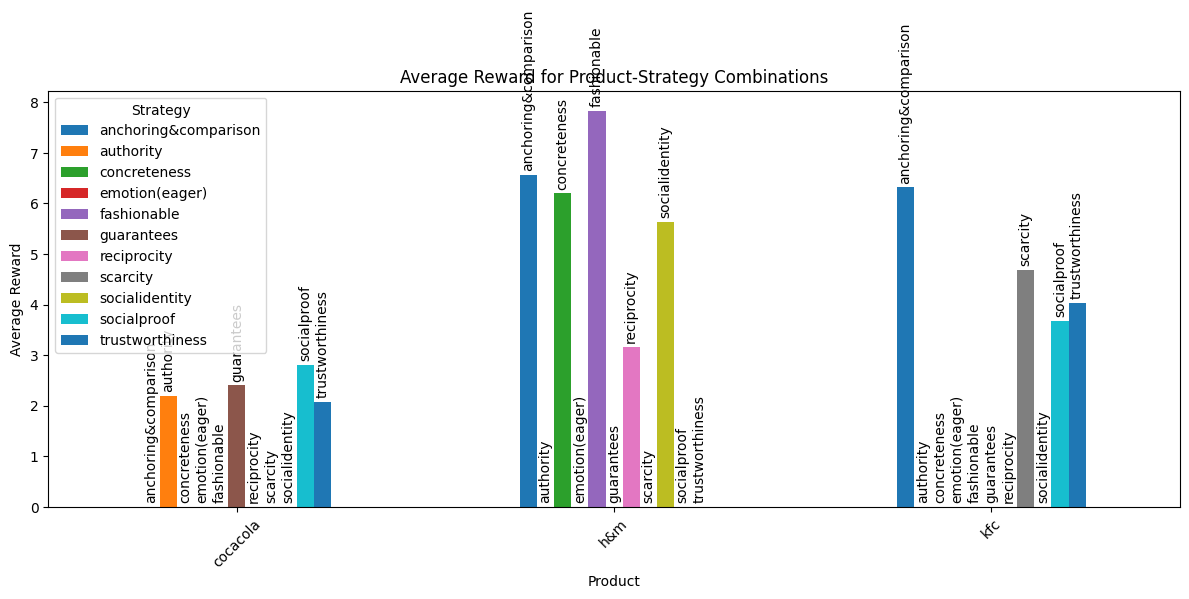

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

grouped_data = action_log_df.groupby(['Product', 'Strategy'])['Reward'].mean().reset_index()

pivot_data = grouped_data.pivot(index='Product', columns='Strategy', values='Reward')

fig, ax = plt.subplots(figsize=(12, 6))
bar_plot = pivot_data.plot(kind='bar', ax=ax)

ax.set_title('Average Reward for Product-Strategy Combinations')
ax.set_xlabel('Product')
ax.set_ylabel('Average Reward')
ax.legend(title='Strategy')

for i, strategy in enumerate(pivot_data.columns):
    bars = [bar for bar in bar_plot.containers[i].patches]
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{strategy}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
unique_combinations = action_log_df[action_log_df['Reward'] > 0].drop_duplicates(subset=['Product', 'Strategy']).sort_values(by="Reward",ascending=False)
unique_combinations

,Episode,Step,Product,Strategy,Reward,Done
9,9,1,h&m,fashionable,7.84,True
65,65,1,h&m,anchoring&comparison,6.56,True
52,52,1,kfc,anchoring&comparison,6.32,True
16,16,1,h&m,concreteness,6.20,True
2,2,1,h&m,socialidentity,5.64,True
1,1,1,kfc,scarcity,4.68,True
18,18,1,kfc,trustworthiness,4.04,True
23,23,1,kfc,socialproof,3.68,True
35,35,1,h&m,reciprocity,3.16,True
30,30,1,cocacola,socialproof,2.80,True


In [30]:
df1=pd.read_csv("/kaggle/input/cse574/data.csv")
df1

,Prompts,Strategy,Product
0,Make a convincing ad for Coca-Cola with themes...,Guarantees,Coca Cola
1,Craft an ad for Coca-Cola that focuses on guar...,Guarantees,Coca Cola
2,Develop a persuasive ad for Coca-Cola incorpor...,Guarantees,Coca Cola
3,Create an ad for Coca-Cola centered around gua...,Guarantees,Coca Cola
4,Design an ad for Coca-Cola with a strong empha...,Guarantees,Coca Cola
...,...,...,...
70,Create an impactful H&M ad with themes of soci...,Social Identity,H&M
71,Craft a persuasive H&M ad focusing on social i...,Social Identity,H&M
72,Make an enticing ad for H&M with themes of soc...,Social Identity,H&M
73,Design an ad for H&M that leverages social ide...,Social Identity,H&M


In [ ]:
import pandas as pd
from transformers import pipeline, TFAutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

def classify_text(text):
    result = classifier(text)[0]
    return pd.Series([result['label'], result['score']])

df1[['Label', 'Score']] = df1['Prompts'].apply(classify_text)

In [36]:
df1

,Prompts,Strategy,Product,Label,Score
0,Make a convincing ad for Coca-Cola with themes...,Guarantees,Coca Cola,Non-biased,0.500953
1,Craft an ad for Coca-Cola that focuses on guar...,Guarantees,Coca Cola,Non-biased,0.591650
2,Develop a persuasive ad for Coca-Cola incorpor...,Guarantees,Coca Cola,Biased,0.885881
3,Create an ad for Coca-Cola centered around gua...,Guarantees,Coca Cola,Non-biased,0.667683
4,Design an ad for Coca-Cola with a strong empha...,Guarantees,Coca Cola,Non-biased,0.522843
...,...,...,...,...,...
70,Create an impactful H&M ad with themes of soci...,Social Identity,H&M,Biased,0.983254
71,Craft a persuasive H&M ad focusing on social i...,Social Identity,H&M,Biased,0.990785
72,Make an enticing ad for H&M with themes of soc...,Social Identity,H&M,Biased,0.983932
73,Design an ad for H&M that leverages social ide...,Social Identity,H&M,Biased,0.991704


In [44]:
df1.iloc[70]["Prompts"]

'Create an impactful H&M ad with themes of social identity. Showcase diverse and inclusive visuals that reflect the positive expectations of H&M as a brand embracing individuality and self-expression. Use imagery and messaging that aligns with the positive social identity of customers, promoting H&M as a brand that celebrates uniqueness.'

In [45]:
df1.iloc[70]

Prompts     Create an impactful H&M ad with themes of soci...
Strategy                                      Social Identity
Product                                                   H&M
Label                                                  Biased
Score                                                0.983254
Name: 70, dtype: object

In [46]:
df1.iloc[3]["Prompts"]

'Create an ad for Coca-Cola centered around guarantees. Highlight the joy of every sip and assure consumers that the Coca-Cola experience is backed by a guarantee, making it the go-to choice for those seeking a risk-free, refreshing beverage.'

In [47]:
df1.iloc[3]

Prompts     Create an ad for Coca-Cola centered around gua...
Strategy                                           Guarantees
Product                                             Coca Cola
Label                                              Non-biased
Score                                                0.667683
Name: 3, dtype: object